# Statistical Modeling and Machine Learning

Today, we will begin our coverage of modeling in Python:

* Today: Statistical Modeling and Machine Learning
* Tuesday, 4/30: Natural Language Processing
* Thursday, 5/2: Optimization
* Tuesday, 5/9: Simulation and Statistical Inference

Friendly Reminders:

* Project Showcase on Thursday, 5/9 (last day of class)

In [1]:
%pylab inline
import datetime as dt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
pd.set_option('display.max_columns', 40)

Populating the interactive namespace from numpy and matplotlib


## Statistical Modeling

Our focus for this topic is on the development of explanatory regression models, using the statsmodels package. Statsmodels is a robust statistical analysis package, and one of three packages (scipy.stats and scikit-learn being the others) that capture some of the most common statistical methodology available in R:

* Linear regression
* Generalized linear models
* Econometric modeling
* Time series analysis
* Survival analysis
* Statistical tests
* Data visualization

For additional detail, please refer to: https://www.statsmodels.org/stable/index.html

Lending Club is a popular peer lending platform that provides the opportunity for individuals and business to acquire loans at potentially lower interest rates than from traditional financial institutions. Potential borrowers can apply for loans directly through the platform, and investors may finance a diverse portfolio of loans in notes that are worth as little as $25. Lending Club releases publicly available data on both approved and declined loans since 2007. This analysis focuses on a sample of approximately 100,000 approved loans issued through September 30, 2015.

In [2]:
!pwd

/Users/weiyaoma/Desktop


In [3]:
# path = '/Users/seanbarnes/Dropbox/Teaching/Courses/BUDT758X/data/'
# df = pd.read_csv(path + 'lendingclub_sample.csv', parse_dates=True)
df = pd.read_csv('lendingclub_sample.csv', parse_dates=True)
df.head()

,id,member_id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,pub_rec,open_acc,total_acc,acc_now_delinq,tot_coll_amt,revol_bal,revol_util,total_credit_rv,tot_cur_bal,int_rate
0,55441634,59043359.0,18000.0,60 months,driver/wharehouseman,10+ years,MORTGAGE,68000.0,Source Verified,medical,066xx,CT,18.48,1.0,Nov-1999,1.0,21.0,21.0,117.0,1.0,15.0,19.0,0.0,0.0,13266.0,64.4%,20600.0,253482.0,17.86%
1,38595688,41379463.0,18000.0,60 months,Supervisor,3 years,MORTGAGE,58000.0,Source Verified,debt_consolidation,894xx,NV,12.97,0.0,Nov-1997,0.0,NaN,NaN,85.0,1.0,16.0,32.0,0.0,0.0,18703.0,58.1%,32200.0,159046.0,16.49%
2,38455988,41249804.0,16000.0,36 months,Mail Clerk,9 years,OWN,49000.0,Not Verified,credit_card,672xx,KS,7.45,0.0,Dec-2002,0.0,NaN,NaN,NaN,0.0,11.0,14.0,0.0,0.0,14864.0,91.2%,16300.0,155379.0,12.69%
3,40362356,43227157.0,4000.0,36 months,MANAGER INTERMODAL OPERATIONS,10+ years,RENT,85000.0,Source Verified,debt_consolidation,910xx,CA,20.40,1.0,Feb-1993,0.0,12.0,12.0,52.0,2.0,15.0,55.0,0.0,0.0,6912.0,55.3%,12500.0,68231.0,12.39%
4,54207722,57748458.0,6000.0,36 months,Management,10+ years,MORTGAGE,75000.0,Not Verified,debt_consolidation,435xx,OH,29.87,0.0,Sep-1992,0.0,NaN,NaN,NaN,0.0,9.0,27.0,0.0,0.0,12104.0,76.6%,15800.0,253166.0,7.89%


In [4]:
# Basic data processing - Remove % from revolving utilization and int_rate variables, convert to float
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float)
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)

In [5]:
# Create discretized income and debt-to-income ratios
df.insert(13, 'dti_cat', pd.cut(df['dti'], 10))

In [6]:
# Calculate length of credit history and create discretized values
df.insert(16, 'credit_history', dt.datetime(2015,9,30) - pd.to_datetime(df['earliest_cr_line']))
df['credit_history'] = df['credit_history'].map(lambda t: t.days / 365.2425)
df.insert(17, 'credit_history_cat', pd.cut(df['credit_history'], np.arange(0,60,5)))

In [7]:
# Preview processed data
df.head()

,id,member_id,loan_amnt,term,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,dti_cat,delinq_2yrs,earliest_cr_line,credit_history,credit_history_cat,inq_last_6mths,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,pub_rec,open_acc,total_acc,acc_now_delinq,tot_coll_amt,revol_bal,revol_util,total_credit_rv,tot_cur_bal,int_rate
0,55441634,59043359.0,18000.0,60 months,driver/wharehouseman,10+ years,MORTGAGE,68000.0,Source Verified,medical,066xx,CT,18.48,"(15.996, 19.995]",1.0,Nov-1999,15.912716,"(15, 20]",1.0,21.0,21.0,117.0,1.0,15.0,19.0,0.0,0.0,13266.0,64.4,20600.0,253482.0,17.86
1,38595688,41379463.0,18000.0,60 months,Supervisor,3 years,MORTGAGE,58000.0,Source Verified,debt_consolidation,894xx,NV,12.97,"(11.997, 15.996]",0.0,Nov-1997,17.911388,"(15, 20]",0.0,NaN,NaN,85.0,1.0,16.0,32.0,0.0,0.0,18703.0,58.1,32200.0,159046.0,16.49
2,38455988,41249804.0,16000.0,36 months,Mail Clerk,9 years,OWN,49000.0,Not Verified,credit_card,672xx,KS,7.45,"(3.999, 7.998]",0.0,Dec-2002,12.829832,"(10, 15]",0.0,NaN,NaN,NaN,0.0,11.0,14.0,0.0,0.0,14864.0,91.2,16300.0,155379.0,12.69
3,40362356,43227157.0,4000.0,36 months,MANAGER INTERMODAL OPERATIONS,10+ years,RENT,85000.0,Source Verified,debt_consolidation,910xx,CA,20.40,"(19.995, 23.994]",1.0,Feb-1993,22.658918,"(20, 25]",0.0,12.0,12.0,52.0,2.0,15.0,55.0,0.0,0.0,6912.0,55.3,12500.0,68231.0,12.39
4,54207722,57748458.0,6000.0,36 months,Management,10+ years,MORTGAGE,75000.0,Not Verified,debt_consolidation,435xx,OH,29.87,"(27.993, 31.992]",0.0,Sep-1992,23.077818,"(20, 25]",0.0,NaN,NaN,NaN,0.0,9.0,27.0,0.0,0.0,12104.0,76.6,15800.0,253166.0,7.89


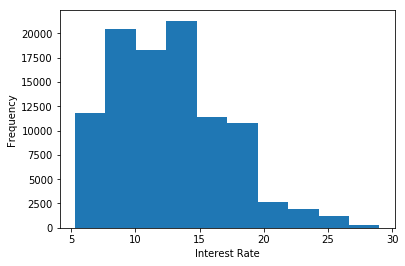

In [8]:
# Visualize distribution of interest rates
df['int_rate'].plot(kind='hist')
plt.xlabel('Interest Rate');

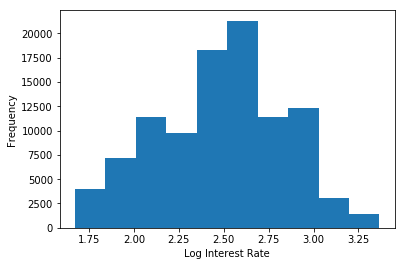

In [9]:
# Visualize distribution of log interest rates
np.log(df['int_rate']).plot(kind='hist')
plt.xlabel('Log Interest Rate');

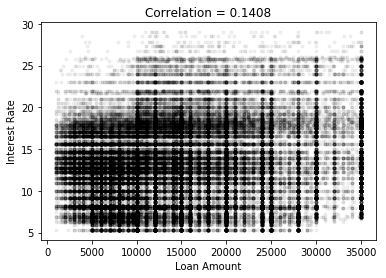

In [10]:
# Visualize relationship between loan amount and interest rate
plt.plot(df['loan_amnt'], df['int_rate'], 'k.', alpha=0.05)
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')
plt.title('Correlation = %.4f' % df['loan_amnt'].corr(df['int_rate']));

In [11]:
# Set up variables for simple linear regression model
X = pd.get_dummies(df['term'], prefix='term', prefix_sep='=', drop_first=True)
X = sm.add_constant(X)
y = np.log(df['int_rate'])

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [12]:
# Preview explanatory variables and dependent variable
pd.concat([X, y], axis=1).head()

,const,term= 60 months,int_rate
0,1.0,1,2.882564
1,1.0,1,2.802754
2,1.0,0,2.540814
3,1.0,0,2.516890
4,1.0,0,2.065596


In [13]:
# Fit linear regression model and report results
model = sm.OLS(endog=y, exog=X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                 2.193e+04
Date:                Thu, 25 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:51:05   Log-Likelihood:                -28194.
No. Observations:               99999   AIC:                         5.639e+04
Df Residuals:                   99997   BIC:                         5.641e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.3805      0.001   1919.278      0.000       2.378       2.383
term= 60 months     0.3192      0.002    148.090      0.000       0.315       0.323
==============================================================================
Omnibus:                     5614.429   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2547.661
Skew:                          -0.183   Prob(JB):                         0.00
Kurtosis:                       2.309   Cond. No.                         2.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# Extract results
print('The R2 is', results.rsquared)
print('The coefficient for the constant is', results.params[0])
print('The coefficient for term=60 months is', results.params[1])

The R2 is 0.17986650967112838
The coefficient for the constant is 2.3804981030552184
The coefficient for term=60 months is 0.3192182449091535


In [15]:
# p-values
results.pvalues

const              0.0
term= 60 months    0.0
dtype: float64

In [16]:
# Define columns to use in multiple linear regression model
cols = ['loan_amnt','term','annual_inc',
       'purpose','dti_cat','credit_history_cat']
cat_cols = ['term','purpose','dti_cat','credit_history_cat']

In [17]:
# Set up variables for multiple linear regression model
X = pd.get_dummies(df[cols], columns=cat_cols, prefix='', prefix_sep='', drop_first=True)
X = sm.add_constant(X)
y = np.log(df['int_rate'])

In [18]:
# Transform numerical variables
X['loan_amnt'] = np.log(X['loan_amnt'])
X['annual_inc'] = np.log(X['annual_inc'])

In [19]:
# Preview explanatory variables and dependent variable
pd.concat([X, y], axis=1).head()

,const,loan_amnt,annual_inc,60 months,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,"(3.999, 7.998]","(7.998, 11.997]","(11.997, 15.996]","(15.996, 19.995]","(19.995, 23.994]","(23.994, 27.993]","(27.993, 31.992]","(31.992, 35.991]","(35.991, 39.99]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]",int_rate
0,1.0,9.798127,11.127263,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.882564
1,1.0,9.798127,10.968198,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2.802754
2,1.0,9.680344,10.799576,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2.540814
3,1.0,8.294050,11.350407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.516890
4,1.0,8.699515,11.225243,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,2.065596


In [20]:
# Fit linear regression model and report results
model = sm.OLS(endog=y, exog=X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               int_rate   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     1474.
Date:                Thu, 25 Apr 2019   Prob (F-statistic):               0.00
Time:                        09:56:26   Log-Likelihood:                -17795.
No. Observations:               99999   AIC:                         3.566e+04
Df Residuals:                   99964   BIC:                         3.599e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.4897      0.025    141.902      0.000       3.441       3.538
loan_amnt              0.0293      0.002     15.841      0.000       0.026       0.033
annual_inc            -0.1173      0.002    -54.836      0.000      -0.121      -0.113
 60 months             0.3200      0.002    147.186      0.000       0.316       0.324
credit_card           -0.0927      0.011     -8.817      0.000      -0.113      -0.072
debt_consolidation     0.0627      0.010      6.023      0.000       0.042       0.083
home_improvement       0.0702      0.011      6.390      0.000       0.049       0.092
house                  0.3972      0.019     21.327      0.000       0.361       0.434
major_purchase         0.0494      0.012      3.980      0.000       0.025       0.074
medical                0.1952      0.014     13.604      0.000       0.167       0.223
moving                 0.3363      0.016     21.528      0.000       0.306       0.367
other                  0.2280      0.011     20.342      0.000       0.206       0.250
renewable_energy       0.3409      0.041      8.380      0.000       0.261       0.421
small_business         0.4150      0.015     28.476      0.000       0.386       0.444
vacation               0.2143      0.016     13.517      0.000       0.183       0.245
wedding                0.6098      0.289      2.107      0.035       0.043       1.177
(3.999, 7.998]        -0.0099      0.007     -1.479      0.139      -0.023       0.003
(7.998, 11.997]       -0.0028      0.006     -0.447      0.655      -0.015       0.010
(11.997, 15.996]       0.0130      0.006      2.086      0.037       0.001       0.025
(15.996, 19.995]       0.0301      0.006      4.813      0.000       0.018       0.042
(19.995, 23.994]       0.0507      0.006      8.017      0.000       0.038       0.063
(23.994, 27.993]       0.0783      0.006     12.144      0.000       0.066       0.091
(27.993, 31.992]       0.1131      0.007     16.958      0.000       0.100       0.126
(31.992, 35.991]       0.1565      0.007     22.120      0.000       0.143       0.170
(35.991, 39.99]        0.2238      0.008     28.030      0.000       0.208       0.239
(5, 10]               -0.1029      0.007    -14.410      0.000      -0.117      -0.089
(10, 15]              -0.1520      0.007    -22.059      0.000      -0.166      -0.139
(15, 20]              -0.1924      0.007    -27.586      0.000      -0.206      -0.179
(20, 25]              -0.2072      0.007    -28.893      0.000      -0.221      -0.193
(25, 30]              -0.2320      0.007    -31.009      0.000      -0.247      -0.217
(30, 35]              -0.2538      0.008    -31.108      0.000      -0.270      -0.238
(35, 40]              -0.2676      0.010    -27.445      0.000      -0.287      -0.248
(40, 45]              -0.2582      0.0

## Scikit-Learn

Scikit-learn is the primary Python package for machine learning, with a specific emphasis on predictive (as opposed to explanatory) modeling. It contains a lot of functionality for performing supervised and unsupervised machine learning tasks, along with support functionality for data processing (e.g., standardization, encoding categorical features, natural language processing) and model evaluation and selection (e.g., cross-validation, hyperparameter tuning).

Today, we will continue to focus on regression for the supervised case, and also explore an unsupervised application (clustering). The general approach for regression will be similar for classification problems.

For additional detail, please refer to: http://scikit-learn.org/stable/user_guide.html#user-guide

Let's begin with a few specific import statements:

In [21]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [22]:
# Drop constant column from statsmodels data frame
X.drop('const', axis=1, inplace=True)
X.head()

,loan_amnt,annual_inc,60 months,credit_card,debt_consolidation,home_improvement,house,major_purchase,medical,moving,other,renewable_energy,small_business,vacation,wedding,"(3.999, 7.998]","(7.998, 11.997]","(11.997, 15.996]","(15.996, 19.995]","(19.995, 23.994]","(23.994, 27.993]","(27.993, 31.992]","(31.992, 35.991]","(35.991, 39.99]","(5, 10]","(10, 15]","(15, 20]","(20, 25]","(25, 30]","(30, 35]","(35, 40]","(40, 45]","(45, 50]","(50, 55]"
0,9.798127,11.127263,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,9.798127,10.968198,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,9.680344,10.799576,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,8.294050,11.350407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,8.699515,11.225243,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [23]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [24]:
# Train linear regression model on training set
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
print('The out-of-sample R2 is', lr.score(X_test, y_test))

The out-of-sample R2 is 0.33557450524732935


In [25]:
# Assemble coefficients into DataFrame
pd.DataFrame({'Feature': X.columns, 'Coefficient': lr.coef_}, columns=['Feature','Coefficient'])

,Feature,Coefficient
0,loan_amnt,0.030860
1,annual_inc,-0.119485
2,60 months,0.318755
3,credit_card,-0.101337
4,debt_consolidation,0.054326
5,home_improvement,0.065929
6,house,0.382337
7,major_purchase,0.042144
8,medical,0.182946
9,moving,0.335423


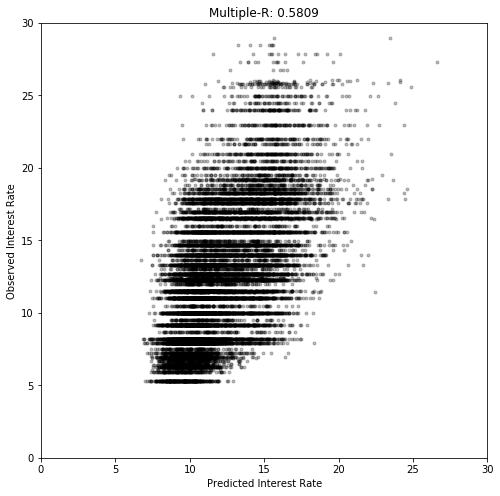

In [26]:
# Predict interest rate for test set, compare to actual interest rates
y_pred = lr.predict(X_test)
plt.figure(figsize=(8,8))
plt.plot(np.exp(y_pred), np.exp(y_test), 'k.', alpha=0.25) # don't forget to transform our predictions!
plt.xlim([0,30])
plt.ylim([0,30])
plt.xlabel('Predicted Interest Rate')
plt.ylabel('Observed Interest Rate')
plt.title('Multiple-R: %.4f' % np.corrcoef(np.exp(y_pred), np.exp(y_test))[0,1]);

Let's try fitting a regression tree model to our data:

In [27]:
# Use linear interest rates
y = df['int_rate']

In [28]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

In [29]:
tree = DecisionTreeRegressor()
tree

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [30]:
tree.fit(X_train, y_train)
print('The out-of-sample R2 is', tree.score(X_test, y_test))

The out-of-sample R2 is -0.18757727652467238


Wow, this is bad!! Oftentimes, the default hyperparameters for machine learning algorithms do not work well. Therefore, we must experiment with the hyperparameters to find a set that performs well. The scikit-learn package offers two primary functions for tuning the hyperparameters of given estimator (algorithm):

* **GridSearchCV** performs an exhaustive search over a given grid of hyperparameter values
* **RandomizedSearchCV** randomly selects combinations of hyperparameter values within a given grid, with the idea that you do not need to perform an exhaustive search to find a good set of hyperparameter values

As indicated by the function names, cross-validation is a critical part of this process. We must evaluate the performance of the hyperparameters on out-of-sample data in order to get a reliable estimate on how the model would perform in practice.

In addition to the aforementioned functions, scikit-learn also offers a set of functions defined for specific algorithms that include cross validation and (effectively) grid search capabilities:

* RidgeCV, LassoCV, and ElasticNetCV for regularized linear regression modeling
* LogisticRegressionCV for regularized logistic regression (classification) modeling

In [31]:
# Run grid search to find best set of parameters
params = {'min_samples_split': [5,10,25,50], 'max_depth': [5,10,25]}
tree_grid = GridSearchCV(estimator=tree, param_grid=params, scoring='r2', cv=5, n_jobs=4)
%time tree_grid.fit(X_train, y_train)

CPU times: user 871 ms, sys: 420 ms, total: 1.29 s
Wall time: 13.9 s


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid={'min_samples_split': [5, 10, 25, 50], 'max_depth': [5, 10, 25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [32]:
# Print best score
tree_grid.best_score_

0.32664138473417487

In [33]:
# Print best parameters
tree_grid.best_params_

{'max_depth': 10, 'min_samples_split': 50}

In [34]:
# Assign best estimator to variable and evaluate performance
tree = tree_grid.best_estimator_
tree.score(X_test, y_test)

0.32728330298973407

In [35]:
# Output tree image to file
export_graphviz(tree, out_file='lending_club_tree.dot', feature_names=X.columns, max_depth=5,
               impurity=False, rounded=True)
!dot -Tpdf lending_club_tree.dot -o lending_club_tree.pdf

Let's explore clustering the potential borrowers:

In [36]:
# Define variables on which to cluster borrows
xvars = ['annual_inc','dti','credit_history','delinq_2yrs']
Xc = df[xvars]
Xc = StandardScaler().fit_transform(Xc)
Xc = pd.DataFrame(Xc, columns=xvars)
Xc.head()

,annual_inc,dti,credit_history,delinq_2yrs
0,-0.117052,-0.073250,-0.161098,0.713818
1,-0.262794,-0.712219,0.102311,-0.367550
2,-0.393963,-1.352347,-0.567399,-0.367550
3,0.130710,0.149404,0.728000,0.713818
4,-0.015032,1.247595,0.783208,-0.367550


In [37]:
# Fit KMeans cluster model
cluster = KMeans(n_clusters=5)
cluster.fit(Xc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [38]:
# Determine cluster sizes
cid = cluster.predict(Xc)
pd.Series(cid).value_counts().sort_index()

0    33605
1     6330
2    40910
3    19151
4        3
dtype: int64

In [39]:
# Assemble cluster centers into dataframe
cdf = pd.DataFrame(cluster.cluster_centers_, columns=Xc.columns)
cdf

,annual_inc,dti,credit_history,delinq_2yrs
0,-0.254292,0.983080,-0.330945,-0.212180
1,0.120673,-0.113708,0.180309,2.949486
2,0.027048,-0.750673,-0.464617,-0.217350
3,0.329195,-0.078892,1.512273,-0.138435
4,116.489403,-2.201213,0.490691,-0.367550


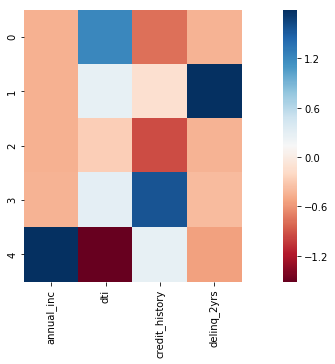

In [40]:
# Visualize cluster centeres as heat map
plt.figure(figsize=(15,5))
sns.heatmap(cdf.apply(lambda col: (col - col.mean()) / col.std()), cmap='RdBu', square=True)

In [41]:
# Transform variable values into 2-dimensional space
pca = PCA(n_components=2).fit(Xc)

In [42]:
# Explained variation
pca.explained_variance_ratio_

array([0.30957589, 0.26740145])

In [43]:
# Principal components
pd.DataFrame(pca.components_, index=[1,2], columns=Xc.columns)

,annual_inc,dti,credit_history,delinq_2yrs
1,0.693956,-0.502947,0.423846,0.292958
2,-0.142097,0.604935,0.614702,0.485803


In [44]:
# Transform cluster data frame
Xct = pca.transform(Xc)
Xct[:5]

array([[ 0.09644965,  0.22006856],
       [ 0.11152786, -0.50916884],
       [ 0.05859898, -1.2894383 ],
       [ 0.53324399,  0.86608332],
       [-0.41362229,  1.05973215]])

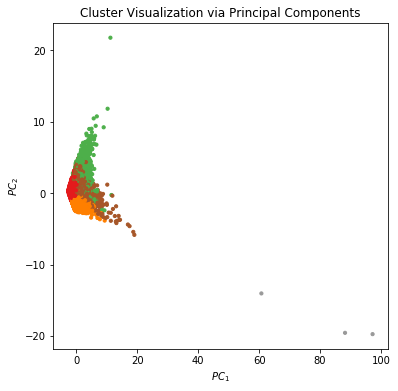

In [45]:
# Visualize clusters
plt.figure(figsize=(6,6))
plt.scatter(x=Xct[:,0], y=Xct[:,1], s=10, c=cid, cmap='Set1')
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')
plt.title('Cluster Visualization via Principal Components');

## Next Time: Natural Language Processing